### RESEARCH ON DATA FROM https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset


#### ADDITIONAL PACKAGES

In [466]:
! pip install cpi

  Using cached cpi-2.0.8-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached cpi-2.0.8-py2.py3-none-any.whl (18.8 MB)


## IMPORTANT NOTES
- Don't drop NA in a column when we need to explore the data in other columns
- When explore a column, if there are NA values, drop the NAs in copy only
- View the data (actual entries to have a sense) and the view the general distribution

## IMPORTED PACKAGES

In [337]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import ast
from itertools import chain
from wordcloud import WordCloud, STOPWORDS
import re

## UTIL FUNCTIONS

In [338]:
def print_df(df):
    with pd.option_context("display.max_columns", None):
        display(df.head(3))
        
def random_color():
    return "#" + "".join(random.choice("0123456789ABCDEF") for _ in range(6))

### CONSTANTS

In [439]:
TOP = 10

## EXPLORATORY DATA ANALYSIS

- Load the dataset

In [339]:
# suppress warnings
meta_data_df = pd.read_csv("../data/movies_metadata.csv", low_memory=False)
credits_df = pd.read_csv("../data/credits.csv")

- Basic information about the dataset

In [340]:
meta_data_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [341]:
meta_data_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


- Column type conversion

In [342]:
meta_data_df["budget"] = pd.to_numeric(meta_data_df["budget"], errors="coerce")
meta_data_df["revenue"] = pd.to_numeric(meta_data_df["revenue"], errors="coerce")
meta_data_df["popularity"] = pd.to_numeric(meta_data_df["popularity"], errors="coerce")
# convert id for JOIN operation
meta_data_df["id"] = meta_data_df["id"].astype(str)
credits_df["id"] = credits_df["id"].astype(str)

- Merge with credit using id

In [343]:
movies_df = pd.merge(meta_data_df, credits_df, on="id", how="left")

In [344]:
print_df(movies_df)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."


In [345]:
# 0 → unknown
# 1 → female
# 2 → male
def extract_cast(cast):
    if pd.isna(cast):
        return None
    
    try:
        data = ast.literal_eval(cast)
        return len(data) if isinstance(data, list) else None
    
    except (ValueError, SyntaxError):
        return None
    
def extract_crew(crew):
    if pd.isna(crew):
        return None
    
    try:
        data = ast.literal_eval(crew)
        return len(data) if isinstance(data, list) else None
    
    except (ValueError, SyntaxError):
        return None
    
def extract_casts(cast):
    if pd.isna(cast):
        return []
    
    try:
        data = ast.literal_eval(cast)
        return [cast["name"] for cast in data] if isinstance(data, list) else []
    
    except (ValueError, SyntaxError):
        return []
    
def extract_sex(cast):
    if pd.isna(cast):
        return None
    
    try:
        data = ast.literal_eval(cast)
        total = len(data)
        if total == 0:
            return None
        
        females = sum(1 for c in data if c.get("gender") == 1)
        males = sum(1 for c in data if c.get("gender") == 2)
        return females / total
    
    except (ValueError, SyntaxError):
        return None
        

# extract features from credits_df
movies_df["num_cast"] = movies_df["cast"].apply(extract_cast)
movies_df["num_crew"] = movies_df["crew"].apply(extract_crew)
movies_df["total_people"] = movies_df["num_cast"] + movies_df["num_crew"]
movies_df["female_ratio"] = movies_df["cast"].apply(extract_sex)
movies_df["cast_name"] = movies_df["cast"].apply(extract_casts)

- Drop meaningless columns

In [346]:
dropped_columns =  ["homepage", "imdb_id", "poster_path", "status", "tagline"]
movies_df = movies_df.drop(columns=dropped_columns)

- Popularity coercion [DEPRECATED]

In [94]:
# convert the popularity to numeric values, NaN (missing values) if can't convert
# meta_data_df["popularity"] = pd.to_numeric(meta_data_df["popularity"], errors="coerce")

- Adult: convert to true/false value and remove noise

In [347]:
movies_df["adult"].value_counts()

movies_df["adult"] = movies_df["adult"].astype(str).str.strip().str.lower()

movies_df["adult"] = movies_df["adult"].map({
    "true": True,
    "false": False
})

movies_df["adult"] = movies_df["adult"].fillna(True)

/tmp/ipykernel_5081/4134363074.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  movies_df["adult"] = movies_df["adult"].fillna(True)


- Production companies (each movie can have a list of production companies)

In [348]:
movies_df["production_companies"] = movies_df["production_companies"].fillna(value="[]")
movies_df['production_companies'] = movies_df['production_companies'].apply(ast.literal_eval)
movies_df['company_names'] = movies_df['production_companies'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])
movies_df["company_num"] = movies_df["company_names"].apply(lambda x: len(x) if isinstance(x, list) else pd.NA)

- Production countries, fill na with a simple empty list of countries

In [349]:
movies_df["production_countries"] = movies_df["production_countries"].fillna(value="[]")
# convert strings to python dict
movies_df['production_countries'] = movies_df['production_countries'].apply(ast.literal_eval)
# convert to a list of names of the countries
movies_df['country_names'] = movies_df['production_countries'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])

- Genre generation

In [350]:
# convert str into python's dict
movies_df["genres"] = movies_df["genres"].apply(ast.literal_eval)
# convert to a list of genres
movies_df['genre_names'] = movies_df['genres'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])

- Collection generation

In [351]:
def extract_collection(value):
    if pd.isna(value):
        return None
    try:
        data = ast.literal_eval(value)
        return data.get("name") if isinstance(data, dict) else None
    except (ValueError, SyntaxError):
        return None

# convert collection into python's dict
movies_df["collection_name"] = movies_df["belongs_to_collection"].apply(extract_collection)
movies_df["has_collection"] = movies_df["collection_name"].notna()

- Spoken languages in the movie, a movie can have multiple spoken languages

In [352]:
def extract_languages(value):
    if pd.isna(value):
        return []
    
    try:
        data = ast.literal_eval(value)
        return [language["iso_639_1"] for language in data] if isinstance(data, list) else []
    except(ValueError, SyntaxError):
        return []

# convert to a list of spoken languages
movies_df["languages"] = movies_df["spoken_languages"].apply(extract_languages)

- Convert datetime into datetime type for manageble

In [467]:
# can convert -> Nan
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')
movies_df['year'] = movies_df['release_date'].dt.year

- Final data frame

In [468]:
movies_df.isna().sum()

adult                        0
belongs_to_collection    41039
budget                       3
genres                       0
id                           0
original_language           11
original_title               0
overview                   954
popularity                   6
production_companies         0
production_countries         0
release_date                90
revenue                      6
runtime                    263
spoken_languages             6
title                        6
video                        6
vote_average                 6
vote_count                   6
cast                         4
crew                         4
num_cast                     4
num_crew                     4
total_people                 4
female_ratio              2424
cast_name                    0
company_names                0
company_num                  0
country_names                0
genre_names                  0
collection_name          41042
has_collection               0
language

In [469]:
print_df(movies_df)

,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,video,vote_average,vote_count,cast,crew,num_cast,num_crew,total_people,female_ratio,cast_name,company_names,company_num,country_names,genre_names,collection_name,has_collection,languages,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",13.0,106.0,119.0,0.230769,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",[Pixar Animation Studios],1,[United States of America],"[Animation, Comedy, Family]",Toy Story Collection,True,[en],1995.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",26.0,16.0,42.0,0.230769,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[TriStar Pictures, Teitler Film, Interscope Co...",3,[United States of America],"[Adventure, Fantasy, Family]",None,False,"[en, fr]",1995.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",7.0,4.0,11.0,0.428571,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[Warner Bros., Lancaster Gate]",2,[United States of America],"[Romance, Comedy]",Grumpy Old Men Collection,True,[en],1995.0


##### TEMP CELL

In [263]:
movies_df["has_collection"].value_counts()

has_collection
False    41042
True      4500
Name: count, dtype: int64

## DATA VISUALIZATION

- Word cloud on titles

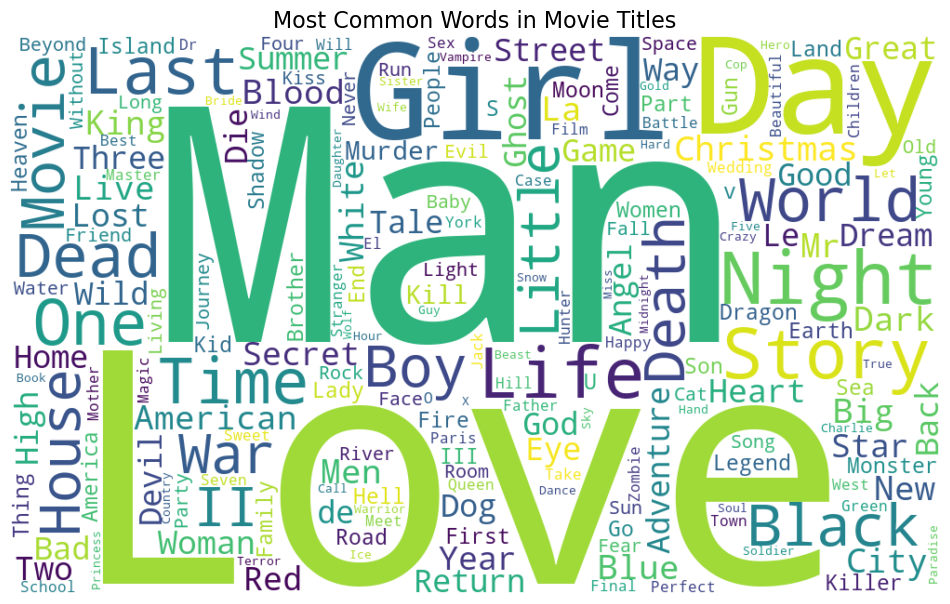

In [356]:
text = " ".join(movies_df["title"].dropna().astype(str))
text.lower()

wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color="white",
    stopwords=STOPWORDS,
    collocations=False
).generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Movie Titles", fontsize=16)
plt.show()

- Budget: Most of the values are 0

In [357]:
movies_df["budget"].value_counts()

budget
0.0            36627
5000000.0        286
10000000.0       261
20000000.0       243
2000000.0        242
               ...  
152000000.0        1
1500.0             1
82000.0            1
1282545.0          1
2153912.0          1
Name: count, Length: 1223, dtype: int64

- revenue: Most of the revenue are 0

In [358]:
movies_df["revenue"].value_counts()

revenue
0.0           38108
12000000.0       20
11000000.0       19
10000000.0       19
2000000.0        18
              ...  
100000.0          1
15073942.0        1
2807854.0         1
1942423.0         1
23833131.0        1
Name: count, Length: 6863, dtype: int64

- popularity values

In [359]:
movies_df["popularity"].describe()

count    45536.000000
mean         2.921856
std          6.002159
min          0.000000
25%          0.386227
50%          1.128305
75%          3.681355
max        547.488298
Name: popularity, dtype: float64

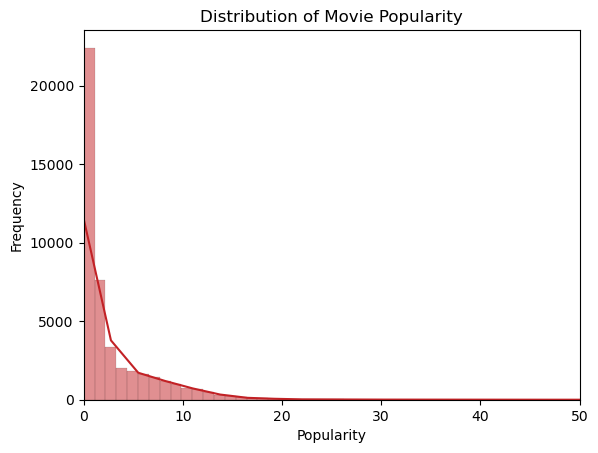

In [361]:
sns.histplot(movies_df["popularity"], bins=500, kde=True, color=random_color())

plt.xlim((0, 50))
plt.title("Distribution of Movie Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()


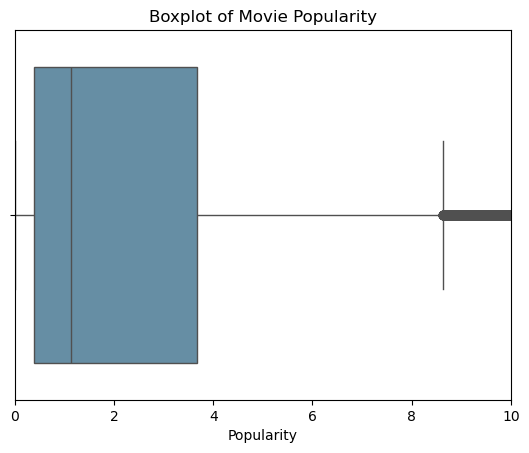

In [362]:
sns.boxplot(x=movies_df["popularity"], color=random_color())
plt.xlim((0, 10))
plt.title("Boxplot of Movie Popularity")
plt.xlabel("Popularity")
plt.show()


- runtime of the movies

In [363]:
movies_df["runtime"].describe()

count    45279.000000
mean        94.126438
std         38.398308
min          0.000000
25%         85.000000
50%         95.000000
75%        107.000000
max       1256.000000
Name: runtime, dtype: float64

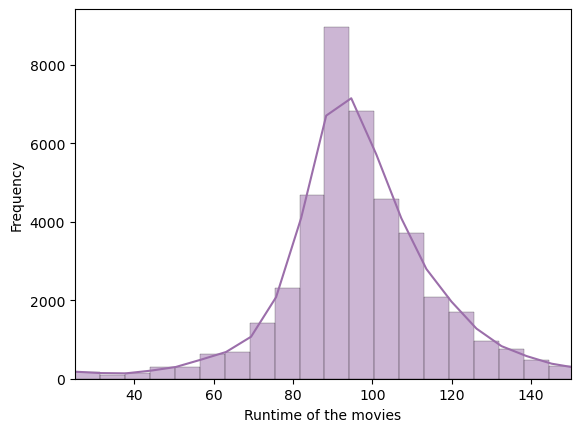

In [368]:
sns.histplot(data=movies_df, x="runtime", color=random_color(), bins=200, kde=True)

plt.xlim((25, 150))
plt.xlabel("Runtime of the movies")
plt.ylabel("Frequency")
plt.show()

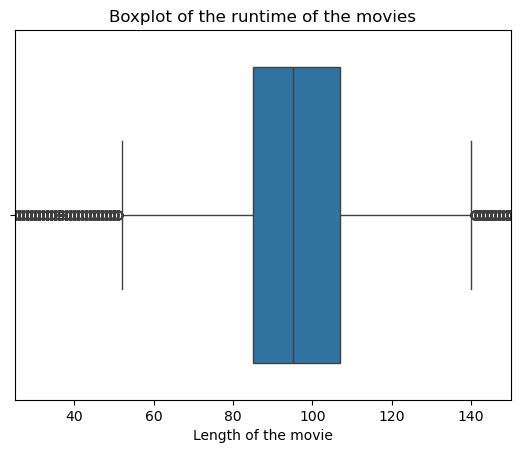

In [369]:
sns.boxplot(data=movies_df, x="runtime")

plt.xlim((25, 150))
plt.xlabel("Length of the movie")
plt.title("Boxplot of the runtime of the movies")
plt.show()

- Changes of runtime

In [470]:
# only used to view the change in runtime
# don't drop the NA values, NA in release_date but still contain valuable data in others
meta_date = movies_df[movies_df["release_date"].notna()]

In [471]:
meta_date['year'] = meta_date['release_date'].dt.year
year_runtime = meta_date.groupby('year')['runtime'].mean().reset_index()

/tmp/ipykernel_5081/687814297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_date['year'] = meta_date['release_date'].dt.year


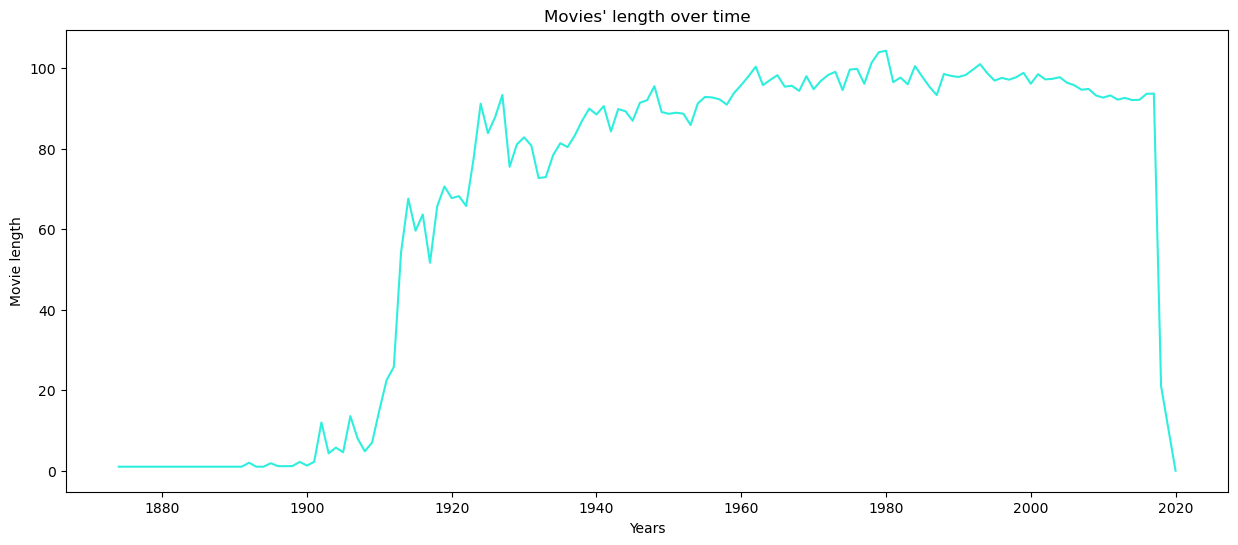

In [472]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=year_runtime, x="year", y="runtime", color=random_color())

plt.xlabel("Years")
plt.ylabel("Movie length")
plt.title("Movies' length over time")
plt.show()

- vote_average: nearly normally distributed with mean 5.6?

In [473]:
movies_df["vote_average"].describe()

count    45536.000000
mean         5.618109
std          1.924362
min          0.000000
25%          5.000000
50%          6.000000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64

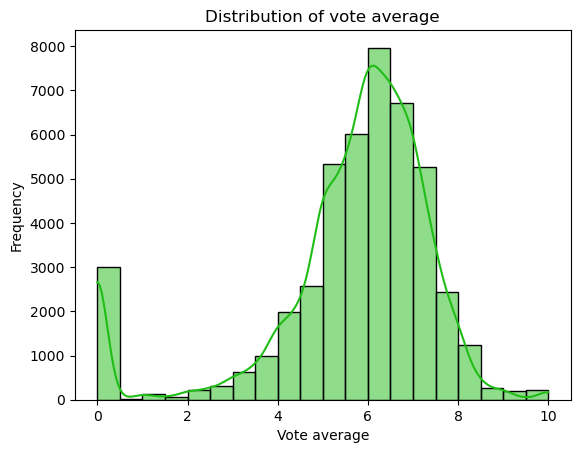

In [376]:
sns.histplot(movies_df["vote_average"], bins=20, kde=True, color=random_color())

plt.title("Distribution of vote average")
plt.xlabel("Vote average")
plt.ylabel("Frequency")
plt.show()

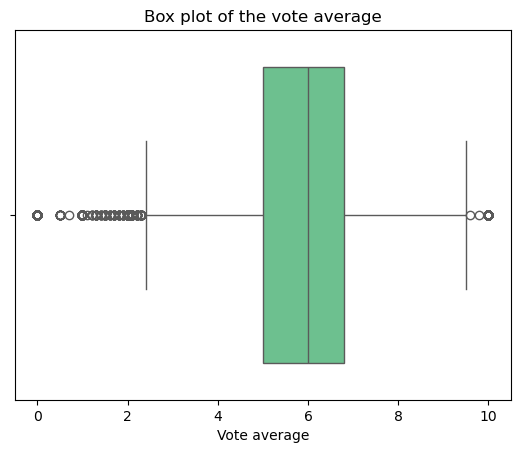

In [377]:
sns.boxplot(x=movies_df["vote_average"], color=random_color())

plt.xlabel("Vote average")
plt.title("Box plot of the vote average")
plt.show()

- vote_count, not so usefull as the number of vote is too small

In [378]:
movies_df["vote_count"].describe()

count    45536.000000
mean       109.788717
std        490.915743
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

In [379]:
(movies_df["vote_count"] > 100).sum()

np.int64(6031)

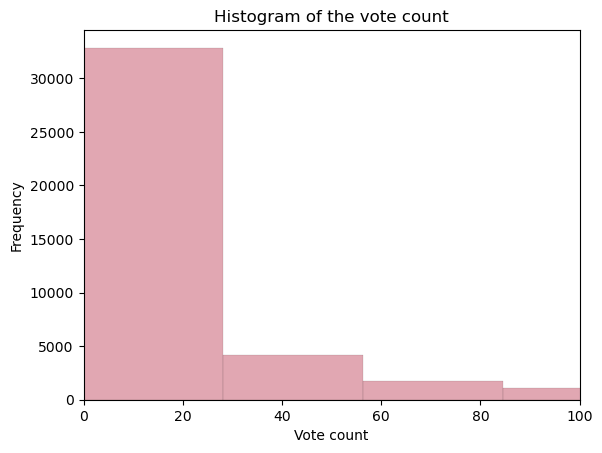

In [380]:
sns.histplot(data=movies_df, x="vote_count", bins=500, color=random_color())

plt.xlim((0, 100))
plt.xlabel("Vote count")
plt.ylabel("Frequency")
plt.title("Histogram of the vote count")
plt.show()

- Most movies have very few votes, but some have high votes 10000

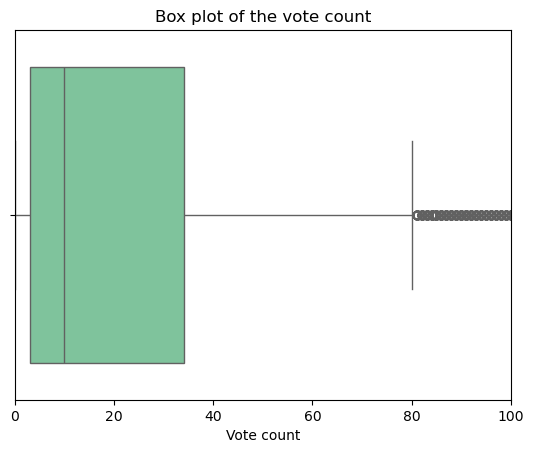

In [381]:
sns.boxplot(data=movies_df, x="vote_count", color=random_color())

plt.xlim((0, 100))
plt.xlabel("Vote count")
plt.title("Box plot of the vote count")
plt.show()

- Countries that produce the movies

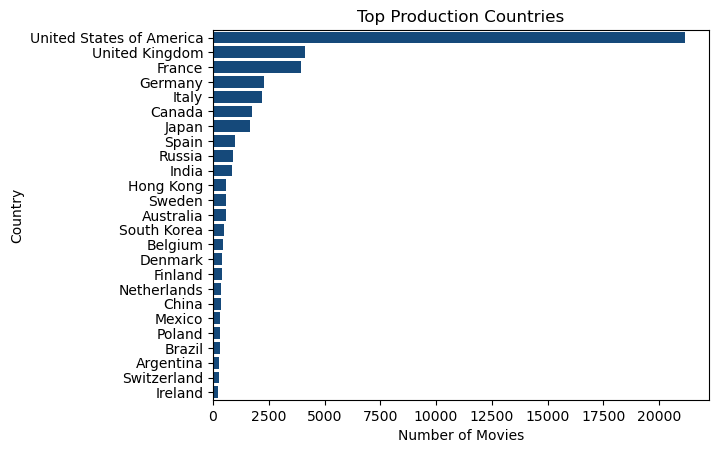

In [387]:
country_counts = pd.Series(list(chain.from_iterable(movies_df['country_names']))).value_counts()
top_countries = country_counts.head(25)

sns.barplot(x=top_countries.values, y=top_countries.index, color=random_color())
plt.title("Top Production Countries")
plt.xlabel("Number of Movies")
plt.ylabel("Country")
plt.show()

- Genre calculation

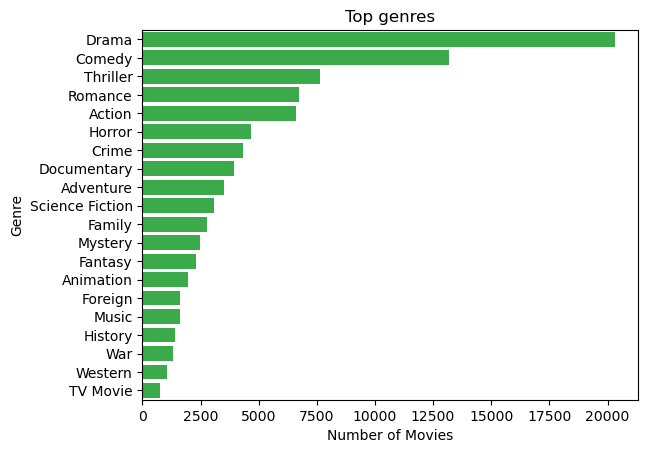

In [390]:
genre_counts = pd.Series(list(chain.from_iterable(movies_df['genre_names']))).value_counts()
top_genres = genre_counts.head(20)

sns.barplot(x=top_genres.values, y=top_genres.index, color=random_color())  
plt.title("Top genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.show()

- Movie collection

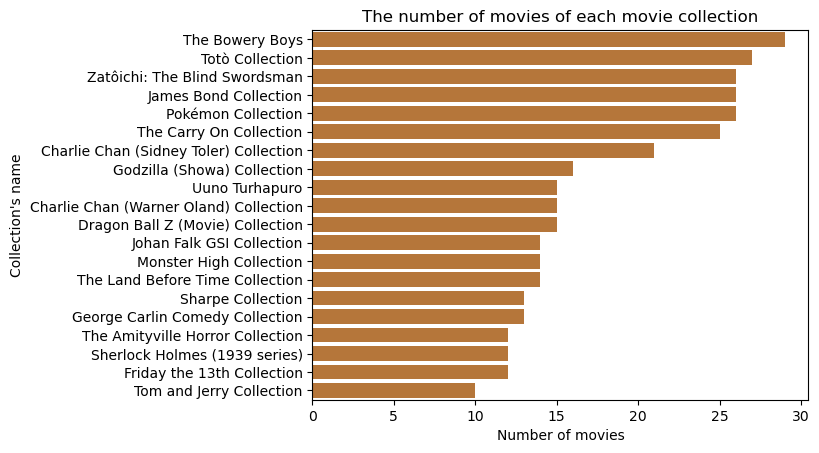

In [394]:
collection_counts = movies_df["collection_name"].value_counts().reset_index()
collection_counts.columns = ["collection_name", "movie_count"]
top_collection = collection_counts.head(20)

sns.barplot(data=top_collection, y="collection_name", x="movie_count", color=random_color())

plt.xlabel("Number of movies")
plt.ylabel("Collection's name")
plt.title("The number of movies of each movie collection")
plt.show()

In [395]:
collection_counts.describe()

,movie_count
count,1695.000000
mean,2.654867
std,2.310989
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,29.000000


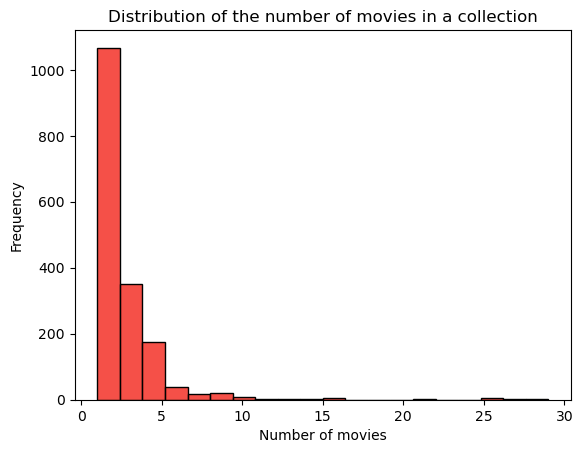

In [400]:
sns.histplot(data=collection_counts, x="movie_count", bins=20, color=random_color())

plt.xlabel("Number of movies")
plt.ylabel("Frequency")
plt.title("Distribution of the number of movies in a collection")
plt.show()

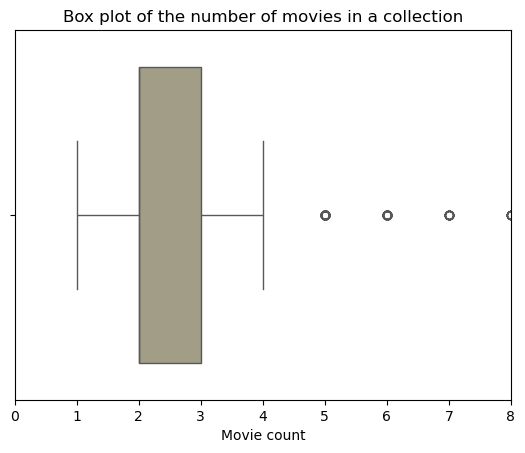

In [401]:
sns.boxplot(data=collection_counts, x="movie_count", color=random_color())

plt.xlim((0, 8))
plt.xlabel("Movie count")
plt.title("Box plot of the number of movies in a collection")
plt.show()

- Production companies

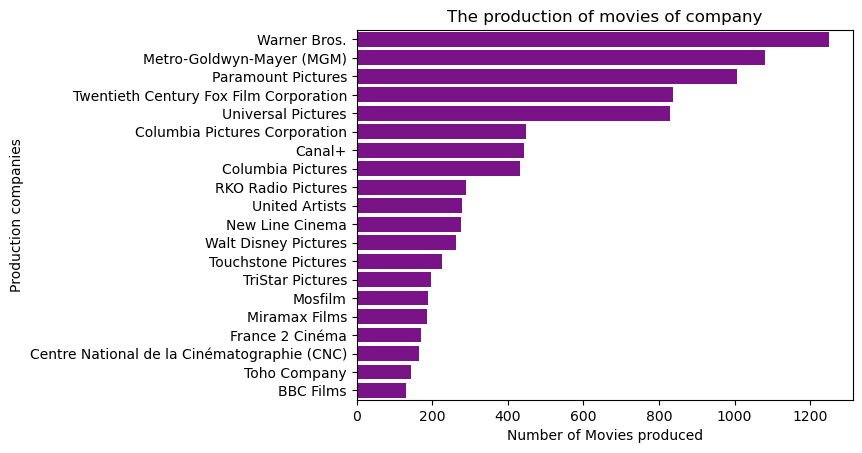

In [402]:
company_counts = pd.Series(list(chain.from_iterable(movies_df['company_names']))).value_counts()
top_companies = company_counts.head(20)

sns.barplot(x=top_companies.values, y=top_companies.index, color=random_color())  
plt.title("The production of movies of company")
plt.xlabel("Number of Movies produced")
plt.ylabel("Production companies")
plt.show()

- The number of companies working on a movie

In [403]:
movies_df["company_num"].value_counts()

company_num
1     16597
0     11903
2      7971
3      4726
4      1950
5       954
6       567
7       316
8       182
9       133
10       67
11       42
12       37
16       21
13       19
14       16
15        9
17        7
20        5
19        5
21        4
26        3
18        3
22        3
25        1
24        1
Name: count, dtype: int64

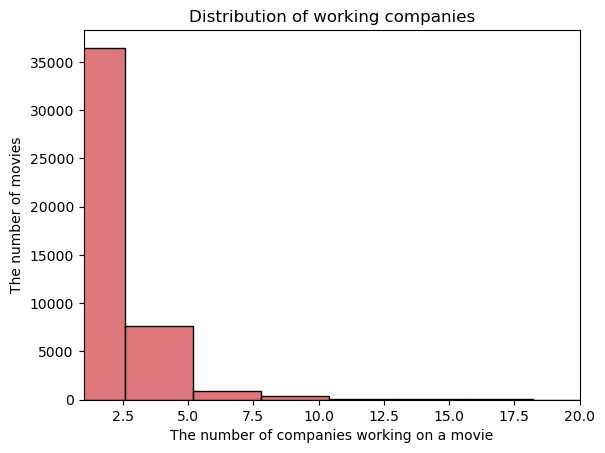

In [415]:
sns.histplot(data=movies_df, x="company_num", color=random_color(), bins=10)

plt.xlim((1, 20))
plt.xlabel("The number of companies working on a movie")
plt.ylabel("The number of movies")
plt.title("Distribution of working companies")
plt.show()

- Spoken languages in movies

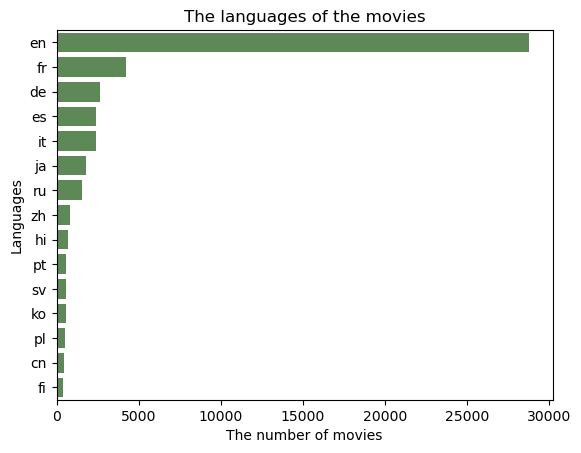

In [416]:
language_counts = pd.Series(list(chain.from_iterable(movies_df['languages']))).value_counts()
top_languages = language_counts.head(15)

sns.barplot(x=top_languages.values, y=top_languages.index, color=random_color())  
plt.title("The languages of the movies")
plt.xlabel("The number of movies")
plt.ylabel("Languages")
plt.show()

- Number of cast and number of crew of a movie

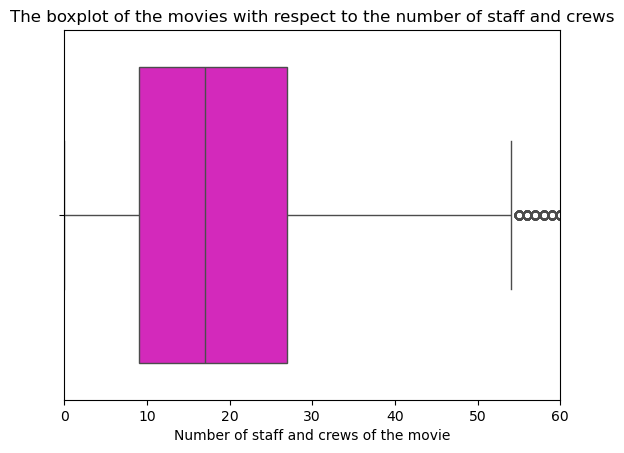

In [417]:
sns.boxplot(data=movies_df, x="total_people", color=random_color())

plt.xlim((0, 60))
plt.xlabel("Number of staff and crews of the movie")
plt.title("The boxplot of the movies with respect to the number of staff and crews")
plt.show()

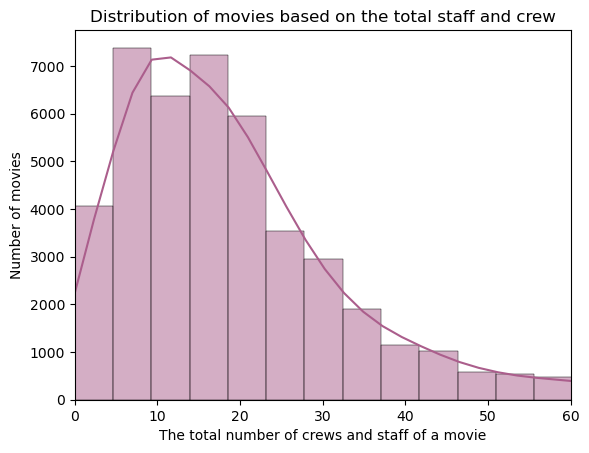

In [422]:
sns.histplot(data=movies_df, x="total_people", bins=100, kde=True, color=random_color())

plt.xlim((0, 60))
plt.xlabel("The total number of crews and staff of a movie")
plt.ylabel("Number of movies")
plt.title("Distribution of movies based on the total staff and crew")
plt.show()

- Movie distribution on female ratio

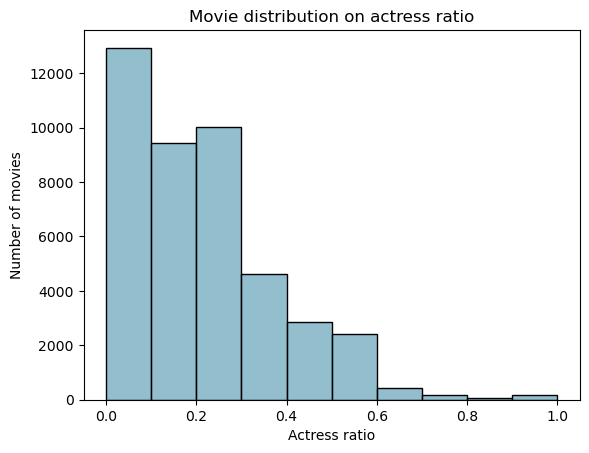

In [425]:
sns.histplot(data=movies_df, x="female_ratio", color=random_color(), bins=10)

plt.xlabel("Actress ratio")
plt.ylabel("Number of movies")
plt.title("Movie distribution on actress ratio")
plt.show()

- Actors and Actresses' popularity

202747


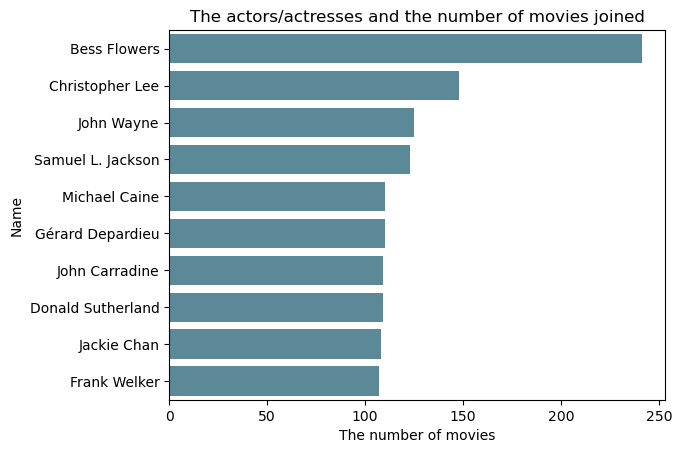

In [427]:
cast_counts = pd.Series(list(chain.from_iterable(movies_df['cast_name']))).value_counts()
top_cast = cast_counts.head(10)
print(len(cast_counts))

sns.barplot(x=top_cast.values, y=top_cast.index, color=random_color())  
plt.title("The actors/actresses and the number of movies joined")
plt.xlabel("The number of movies")
plt.ylabel("Name")
plt.show()

### BUDGET AND REVENUE (MONEY - WHAT ABOUT INFLATION)

- Movies' budget (most of the values are 0 -> missing) and Movies' revenue (most of the values are 0 as well)

In [491]:
# filter 0.0 and NA
budget_df = movies_df[(movies_df["budget"] != 0.0) & (movies_df["budget"].notna())]
# filter 0.0 and NA
revenue_df = movies_df[(movies_df["revenue"] != 0.0) & (movies_df["revenue"].notna())]
# together
money_df = movies_df[(movies_df["budget"] != 0.0) & (movies_df["budget"].notna()) & (movies_df["revenue"] != 0.0) & (movies_df["revenue"].notna())]

- Year distribution

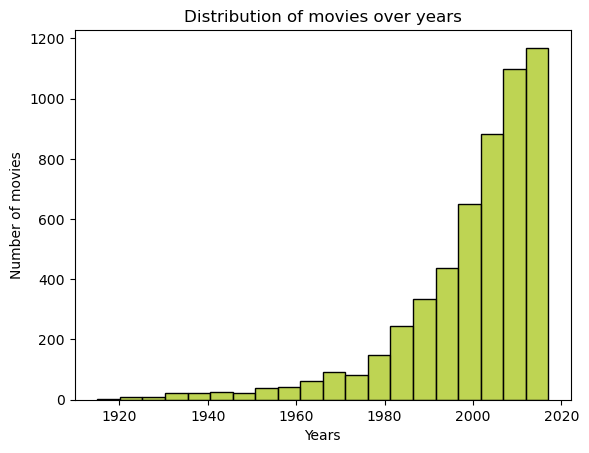

In [496]:
sns.histplot(data=money_df, x="year", bins=20, color=random_color())

plt.xlabel("Years")
plt.ylabel("Number of movies")
plt.title("Distribution of movies over years")
plt.show()

#### BUDGET

- Top expensive movies

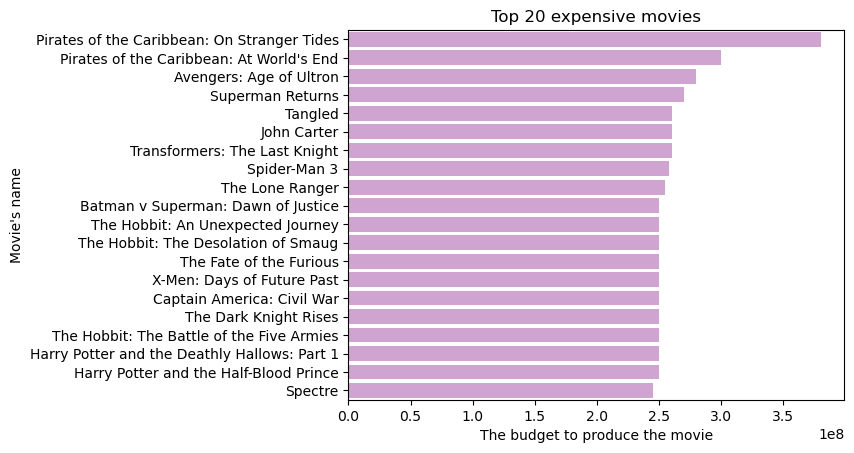

In [479]:
top_expensive = 20
top_expensive_movies = budget_df.sort_values(by="budget", ascending=False).head(top_expensive)

sns.barplot(data=top_expensive_movies, x="budget", y="title", color=random_color())

plt.xlabel("The budget to produce the movie")
plt.ylabel("Movie's name")
plt.title(f"Top {top_expensive} expensive movies")
plt.show()

- Top expensive collections of movies

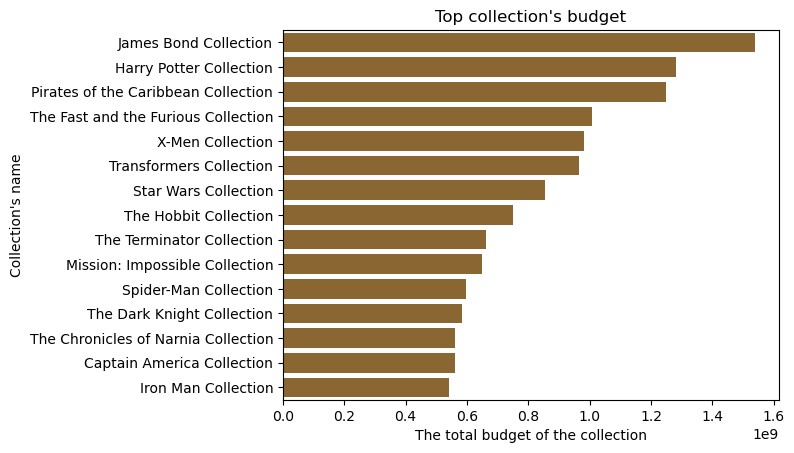

In [480]:
top_collection_budget_num = 15
collection_budget = budget_df.groupby("collection_name")["budget"].sum().reset_index()
collection_budget.columns = ["name", "total_budget"]
top_collection_budget = collection_budget.sort_values(by="total_budget", ascending=False).head(top_collection_budget_num)

sns.barplot(data=top_collection_budget, x="total_budget", y="name", color=random_color())

plt.xlabel("The total budget of the collection")
plt.ylabel("Collection's name")
plt.title("Top collection's budget")
plt.show()

- Distribution of budget

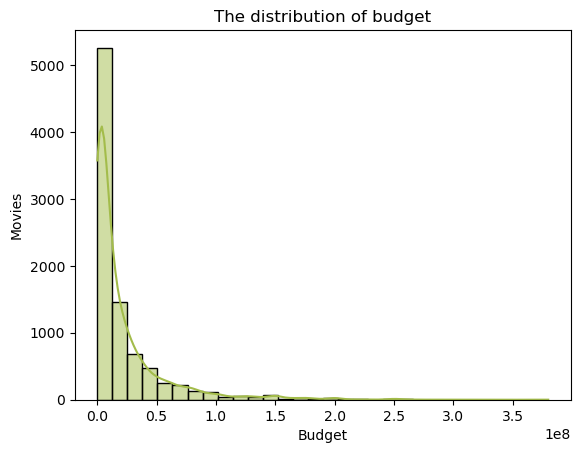

In [481]:
sns.histplot(data=budget_df, x="budget", bins=30, kde=True, color=random_color())

plt.xlabel("Budget")
plt.ylabel("Movies")
plt.title("The distribution of budget")

plt.show()

- Movie in collections or not in collections with budget

In [482]:
budget_df["has_collection"].value_counts()

has_collection
False    7325
True     1587
Name: count, dtype: int64

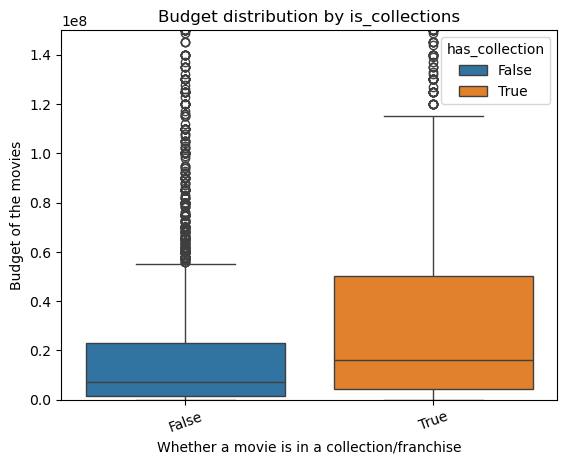

In [483]:
sns.boxplot(data=budget_df, x="has_collection", y="budget", hue="has_collection")

plt.ylim((0.0e8, 1.5e8))
plt.xticks(rotation=20)
plt.xlabel("Whether a movie is in a collection/franchise")
plt.ylabel("Budget of the movies")
plt.title("Budget distribution by is_collections")
plt.show()

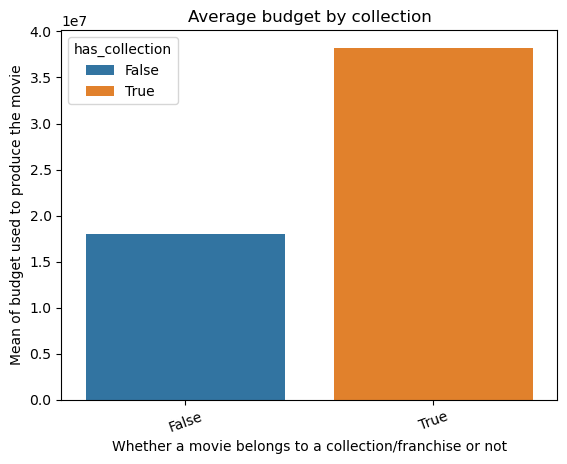

In [484]:
collection_budget = budget_df.groupby("has_collection")["budget"].mean()
collection_budget = collection_budget.reset_index()

sns.barplot(data=collection_budget, x="has_collection", y="budget", hue="has_collection")

plt.xticks(rotation=20)
plt.xlabel("Whether a movie belongs to a collection/franchise or not")
plt.ylabel("Mean of budget used to produce the movie")
plt.title("Average budget by collection")
plt.show()

In [485]:
budget_genres_exploded = budget_df.explode(column="genre_names")
budget_genres_exploded = budget_genres_exploded.reset_index(drop=True)

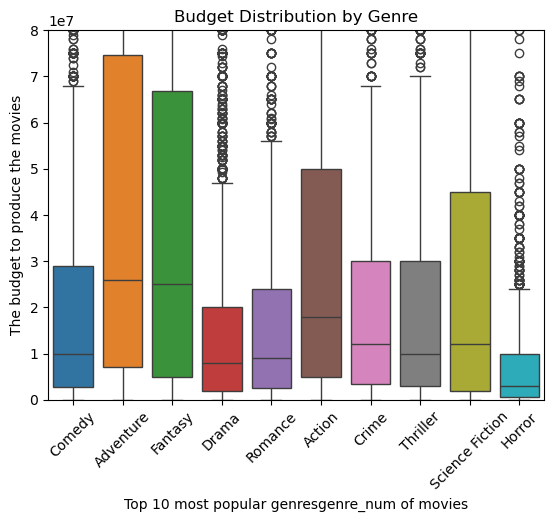

In [486]:
# get the top list of genre
genre_num = 10
colors = [random_color() for i in range(0, genre_num)]
# popular genres
top_genres = budget_genres_exploded['genre_names'].value_counts().nlargest(genre_num).index
# only get the exploded data of those values
sns.boxplot(data=budget_genres_exploded[budget_genres_exploded['genre_names'].isin(top_genres)], x='genre_names', y="budget", hue="genre_names")

plt.xticks(rotation=45)
plt.ylim((0.0e8, 0.8e8))
plt.xlabel(f"Top {len(top_genres)} most popular genresgenre_num of movies")
plt.ylabel("The budget to produce the movies")
plt.title("Budget Distribution by Genre")
plt.show()

- Average budget per genre

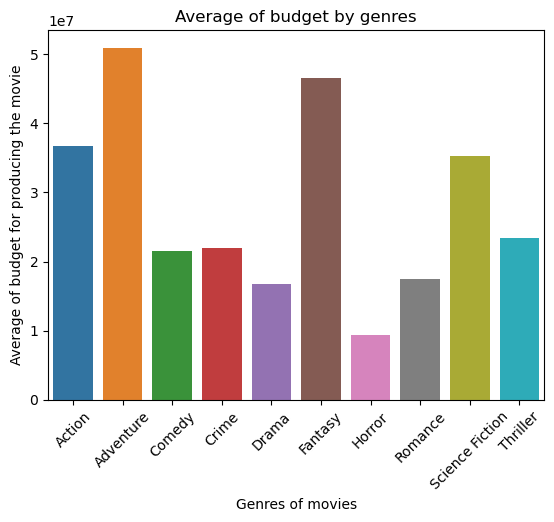

In [436]:
# genre and average budget
genre_budget = budget_genres_exploded.groupby('genre_names')['budget'].mean()
genre_budget = genre_budget.reset_index()
genre_budget.columns = ["name", "budget"]

sns.barplot(data=genre_budget[genre_budget["name"].isin(top_genres)], x="name", y="budget", hue="name")

plt.xlabel("Genres of movies")
plt.ylabel("Average of budget for producing the movie")
plt.xticks(rotation=45)
plt.title("Average of budget by genres")
plt.show()

#### BUDGET AND REVENUE RELATIONSHIP
- The key point: Popularity != Profitability.
- Big-budget blockbusters can attract millions of viewers, but if the cost is astronomical, the ROI can still be low.
- Small indie hits may be less “popular” globally, but because they cost very little, their ROI can skyrocket.

#### REVENUE

- Top movies have the highest revenue (popularity, most people watched this movie)

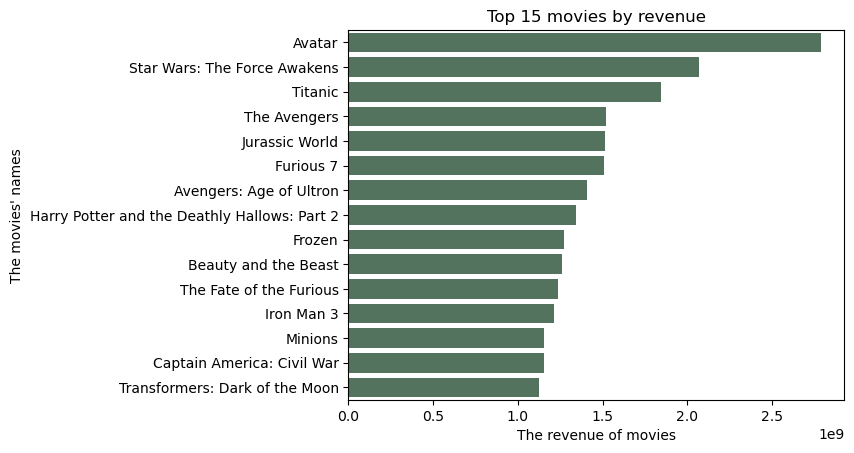

In [463]:
top_revenue_num = 15
top_revenue = revenue_df.sort_values(by="revenue", ascending=False).head(top_revenue_num)

sns.barplot(data=top_revenue, x="revenue", y="title", color=random_color())
plt.xlabel("The revenue of movies")
plt.ylabel("The movies' names")
plt.title(f"Top {top_revenue_num} movies by revenue")
plt.show()

## BUILDING MODELS

In [438]:
print_df(movies_df)

,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,video,vote_average,vote_count,cast,crew,num_cast,num_crew,total_people,female_ratio,cast_name,company_names,company_num,country_names,genre_names,collection_name,has_collection,languages
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",13.0,106.0,119.0,0.230769,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",[Pixar Animation Studios],1,[United States of America],"[Animation, Comedy, Family]",Toy Story Collection,True,[en]
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",26.0,16.0,42.0,0.230769,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[TriStar Pictures, Teitler Film, Interscope Co...",3,[United States of America],"[Adventure, Fantasy, Family]",None,False,"[en, fr]"
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",7.0,4.0,11.0,0.428571,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[Warner Bros., Lancaster Gate]",2,[United States of America],"[Romance, Comedy]",Grumpy Old Men Collection,True,[en]


In [437]:
movies_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45542 entries, 0 to 45541
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  45542 non-null  bool          
 1   belongs_to_collection  4503 non-null   object        
 2   budget                 45539 non-null  float64       
 3   genres                 45542 non-null  object        
 4   id                     45542 non-null  object        
 5   original_language      45531 non-null  object        
 6   original_title         45542 non-null  object        
 7   overview               44588 non-null  object        
 8   popularity             45536 non-null  float64       
 9   production_companies   45542 non-null  object        
 10  production_countries   45542 non-null  object        
 11  release_date           45452 non-null  datetime64[ns]
 12  revenue                45536 non-null  float64       
 13  r